In [1]:
## Libraries
import numpy as np
import matplotlib.pyplot as plt


## Plot settings
plt.rc('xtick', direction='in', labelsize=14)
plt.rc('ytick', direction='in', labelsize=14)
plt.rc('axes', labelsize=20, titlesize=22)
plt.rc('legend', fontsize=14)
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']
plt.rcParams['mathtext.fontset'] = 'cm'

In [2]:
## Read coordinates and indices

grid_coordinates = []
with open('../../Grids/Pe_grid.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(',')
        point = (float(elements[0]),float(elements[1]))
        grid_coordinates.append(point)
        line = reader.readline()

jump_coordinates = []
with open('../../Grids/Pe_jump_coordinates.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(' ')
        data_block = []
        for ele in elements:
            temp = ele.replace('(', '').replace(')', '')
            if temp != 'stop':
                x = temp.split(',')[0]
                y = temp.split(',')[1]
                point = (float(x),float(y))
                data_block.append(point)
            else:
                break
        line = reader.readline()
        jump_coordinates.append(data_block)

jump_indices = []
with open('../../Grids/Pe_jump_indices.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(' ')
        data_block = []
        for ele in elements:
            if ele != 'stop':
                data_block.append(int(ele))
            else:
                break
        line = reader.readline()
        jump_indices.append(data_block)

bott_indices = []
with open('Pe_Bott_indices.txt', 'r') as reader:
    line = reader.readline()
    
    while line != '':
        ele = line.replace('(', '').replace(')', '')
        elements = ele.split(',')
        package = (float(elements[0]), int(elements[1]))
        line = reader.readline()
        bott_indices.append(package)

# For drawing vertices use grid_coordinates
# For drawing lines use jump_coordinates
# For indices use jump_indices

def rotation(phi):
    operator = np.array([[np.cos(phi), -np.sin(phi)],[np.sin(phi), np.cos(phi)]])
    return operator

def translation(vector, coordinate):
    operator = vector + np.array([coordinate[0], coordinate[1]])
    return operator

def argz(z):
    a = np.angle(z)
    if a >= 0:
        return a
    else:
        return 2*np.pi + a

# First we make sure the grid is centered by finding zero and correcting
def origin_finder(grid, grain):
    null0 = [ele for count, ele in enumerate(grid) if np.linalg.norm(ele) <= 10**(-grain)]
    if len(null0) != 1:
        if len(null0) < 1:
            print(f'No candidate for the symmetry point has been found. Try reducing grain')
        else:
            print(f'More than one candidate for the symmetry point has been found. Try increasing grain')

    elif len(null0) == 1:
        origin_point = np.array(null0[0])
        return origin_point
    
# Find origin point and translate every point
origin_point = origin_finder(grid_coordinates, 8)

grid_translated = [translation(x, -origin_point) for x in grid_coordinates]
jump_translated = [[translation(x, -origin_point) for x in i] for i in jump_coordinates]

# Compare x and y components seperatly to for the maximal distances along each axis
xs = [x for x,y in grid_translated]
ys = [y for x,y in grid_translated]

xs_length = abs(max(xs)) + abs(min(xs))
ys_length = abs(max(ys)) + abs(min(ys))

# We can now scale all xs and ys to fit inside a unit square
xs_scaled = [i/xs_length for i in xs]
ys_scaled = [i/ys_length for i in ys]
grid_scaled = [(x,y) for x, y in zip(xs_scaled, ys_scaled)]

# Same thing for all jump coodinates
jump_scaled = []
for i in jump_coordinates:
    xs_temp = [j[0]/xs_length for j in i]
    ys_temp = [j[1]/ys_length for j in i]
    jump_temp = [(x,y) for x, y in zip(xs_temp, ys_temp)]
    jump_scaled.append(jump_temp)


# The new vertices are stored in grid_scaled
# The new jumps are stored in jump_scaled

## IMPORTANT WE WILL USE THE GRID SCALED FOR ROTATIONS THIS MAKES THE WORK EASIER ##

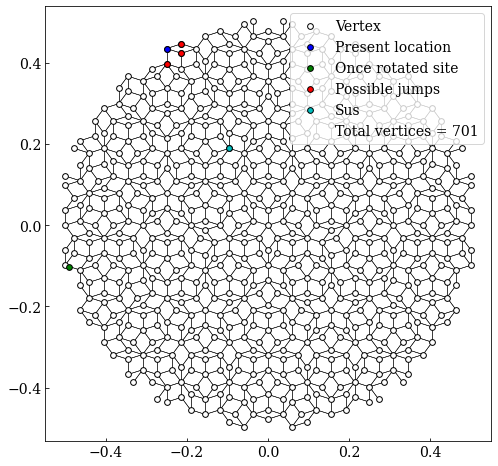

In [3]:
# Define figure
fig, ax = plt.subplots(figsize=(8,8))

# Plot all possible paths between vertices
for i,j in zip(grid_scaled, jump_scaled):
    xs = [w[0] for w in j]
    ys = [w[1] for w in j]
    for l,k in zip(xs,ys):
        ax.plot([i[0], l], [i[1], k], color= 'k', zorder= 1, linewidth= 0.5)


# Choose index to highlight a specific vertex and its connecting points
# We will use to attempt to make rotation operator, keep ind= 42
ind_choice = 0

xs_jumps = [w[0] for w in jump_scaled[ind_choice]]
ys_jumps = [w[1] for w in jump_scaled[ind_choice]]

marker_size = 33

coors = np.matmul(rotation((2*np.pi)/(5)),grid_scaled[ind_choice])
x_rot = coors[0]
y_rot = coors[1]

ax.scatter(x= xs_scaled, y= ys_scaled, s= marker_size, facecolor= 'w', edgecolor= 'k', label= "Vertex", linewidth= 1)
ax.scatter(x= xs_scaled[ind_choice], y= ys_scaled[ind_choice], s= marker_size, facecolor= 'b', edgecolor= 'k', label= "Present location", linewidth= 1)
ax.scatter(x= x_rot, y= y_rot, s= marker_size, facecolor= 'g', edgecolor= 'k', label= "Once rotated site", linewidth= 1)
ax.scatter(x= xs_jumps, y= ys_jumps, s= marker_size, facecolor= 'r', edgecolor= 'k', label= "Possible jumps", linewidth= 1)
ax.scatter(x= xs_scaled[57], y= ys_scaled[57], s= marker_size, facecolor= 'c', edgecolor= 'k', label= "Sus", linewidth= 1)
ax.plot([],[], linestyle= '', label= "Total vertices = {}".format(len(grid_coordinates)))

ax.legend(loc= 1)

ax.axis('equal')
plt.show()

In [4]:
# This takes a vector from the basis of lattice sites and rotates it n-fold and assigns to a new vector in the same
def rot_op(site, n):
    # Site is a vector describing the coordinate of a supposed occupied site, which we want rotate (1/n)-fold
    # Rads tells the operator how much we should rotate
    rads = (2*np.pi)/(n)
    
    # Rotate site
    rot_site = np.matmul(rotation(rads), np.array(site))
    
    # We aim to assign the rotated site to an already exisiting coordinate pair, so we will compare with grid_scaled
    
    # Find sites close enough
    grain2 = -1
    close_by_ele = [(ele, count) for count, ele in enumerate(grid_scaled) if np.linalg.norm(np.array(ele) - rot_site) <= 10**(grain2)]
    closest_by_ele_dist = [np.linalg.norm(np.array(ele) - rot_site) for count, ele in enumerate(grid_scaled) if np.linalg.norm(np.array(ele) - rot_site) <= 10**(grain2)]
    closests_ind = closest_by_ele_dist.index(min(closest_by_ele_dist))
    final_close = close_by_ele[closests_ind]
    
    # This element comes with an index which we use to assign the rotated site to the preexisting coordinates
    new_site = final_close[0]
    new_x = new_site[0]
    new_y = new_site[1]
    ns_index = final_close[1]
    return (new_x, new_y), ns_index
    

# We now use the above function to construct an explicit rotation operator by applying and extracting the index for every basis element
dim = len(grid_scaled)
R = np.zeros((dim,dim),dtype= np.complex128)
indices = []
new_coordinates = []
for w in range(dim):
    coor, rot_index = rot_op(grid_scaled[w], 5)
    indices.append(rot_index)
    new_coordinates.append(coor)

complex_coor = [complex(*x) for x in grid_scaled]
complex_coor_rot = [complex(*x) for x in new_coordinates]
# With the new coordinates of each transformed coordinate we may determine the phase between 
#phases = [y/x for x, y in zip(complex_coor, complex_coor_rot)]
#theta = [arg(z) for z in phases]

for i, j in zip(range(dim), indices):
    # Note the order is to make sure in the picture of a matrix being made of column vectors, that we get the right non-zero entries
    # If we flip the order we get the transpose. Reason being that np intreprets entries along every row constituting the matrix in stead
    R[j][i] = 1

In [5]:
## DEFINITION OF USEFUL FUNCTIONS

def Hamil_solve(z, w, B):
    # Define now a skeleton of the Hamiltonian 
    dim_H = len(z)
    H = np.zeros((dim_H, dim_H), dtype= np.complex128)
    k_H = [x for x in range(0, dim_H)]
    # Calculate Peierls phase factor according to the 1st artcle 
    
    # Start by finding the tile length
    tile_lens = [np.linalg.norm(np.array(z[0]) - np.array(x)) for x in w[0]]
    tile_lens_sum = np.sum(tile_lens)
    l  = tile_lens_sum/len(tile_lens)
    phi = B * l**2
    phi_0 = 2 * np.pi
    jump_products = []
    for i, j in zip(z, w):
        products = [i[0]*k[1] - k[0]*i[1] for k in j]
        jump_products.append(products)
    phase_factors = []
    for i, j in zip(z, jump_products):
        phases = [(phi/(2 * l**2)) * k for k in j]
        phase_factors.append(phases)

    # Scaling via J, maybe energy factor
    J = 1
    # Fill out the Hamiltonian according to the psi vector, i.e. the basis chosen through generation of the tiling
    for x, y, z in zip(k_H, jump_indices, phase_factors):
        for k, t in zip(y, z):
            H[x, k] = -J * np.exp(1j * t)

    # Now we find the eigenvalues and eigenvectors
    # Note that eigh returns normalized eigenvectors!
    # Note the eigenvectors are arranged in a matrix so eig_vecs[:,i] chooses the i'th column which is the i'th eigenvector
    eig_vals, U = np.linalg.eigh(H)
    eig_vecs = np.array([U[:,i] for i in range(len(U))])
    return eig_vals, eig_vecs

# We want to know when phi/phi0 = 1, this happens when phi = 2pi
B_full = 2127.2827861030087
evals, evecs = Hamil_solve(grid_scaled, jump_scaled, (0.25)*B_full)

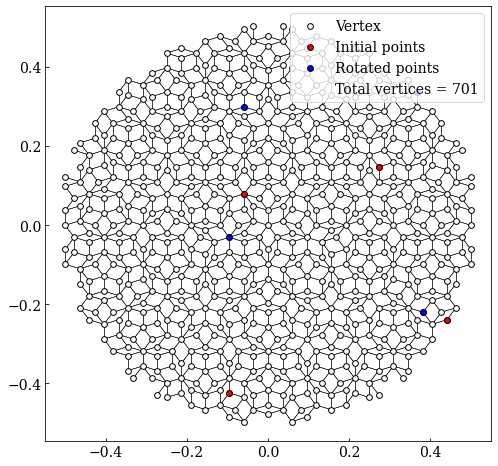

In [6]:
# Proof of concept for the R operator
# Take a matrix of 4 random entries
rand_indices = np.random.randint(0,dim, 4)
# Generate a vector of chosen sites
vec = np.zeros(dim, dtype= int)
for i in rand_indices:
    vec[i] = 1

# Apply R and extract indices
rot_vec = np.matmul(R,vec)
rot_ind = [index for index, ele in enumerate(rot_vec) if ele == 1]

# Get coordinates from grid_scaled
coors_rot = [grid_scaled[i] for i in rot_ind]

# Get original coordinates
coors_ini = [grid_scaled[i] for i in rand_indices]

# Define figure
fig, ax = plt.subplots(figsize=(8,8))

# Plot all possible paths between vertices
for i,j in zip(grid_scaled, jump_scaled):
    xs = [w[0] for w in j]
    ys = [w[1] for w in j]
    for l,k in zip(xs,ys):
        ax.plot([i[0], l], [i[1], k], color= 'k', zorder= 1, linewidth= 0.5)


# Choose index to highlight a specific vertex and its connecting points
# We will use to attempt to make rotation operator, keep ind= 42
ind_choice = 42

marker_size = 33

ax.scatter(x= xs_scaled, y= ys_scaled, s= marker_size, facecolor= 'w', edgecolor= 'k', label= "Vertex", linewidth= 1)
for w, text, col in zip([coors_ini, coors_rot], ["Initial points", "Rotated points"], ['r', 'b']):
    xs = [x for x,y in w]
    ys = [y for x,y in w]
    ax.scatter(xs, ys, s= marker_size, facecolor= col, edgecolor= 'k', label= text, linewidth= 1)
ax.plot([],[], linestyle= '', label= "Total vertices = {}".format(len(grid_coordinates)))

ax.legend(loc= 1)

plt.show()

In [7]:
# Function for calculating the eigenvalue of the rotation operator on an eigenvector of the Hamiltonian
# This will be used for estimating angular momentum
def rot_eval(evec):
    # Apply rotation to eigenvector
    rot = np.matmul(R,evec)

    # Check of phases
    phases = [y/x for x,y in zip(evec, rot)]

    # Give argument
    args = [argz(x) for x in phases]
    # Make an average
    avg_arg = (1/(len(rot))) * np.sum(args)
    return avg_arg

# One could use this but we use below method via diagoal matrix
"""# Calculate the different average arguments
args = [rot_eval(x) for x in evecs]
with open('../../Separate_files/Pe_args.txt', 'w') as file:
    for i in args:
        file.write(f'{i}')
        file.write('\n')"""

# Calculate the diagonal matrix D containing eigenvalues of R
# This is done by matrix elements np.vdot(i,R,j)

D = np.zeros((dim,dim), dtype= np.complex128)
for i, elei in enumerate(evecs):
    for j, elej in enumerate(evecs):
        D[i][j] = np.vdot(elei, np.matmul(R,elej))

rot_evals_diag = np.diag(D)
diag_args = [argz(x) for x in rot_evals_diag]

with open('../../Separate_files/Pe_args.txt', 'w') as file:
    for i in diag_args:
        file.write(f'{i}')
        file.write('\n')